# Import modules and define useful functions

In [13]:
%matplotlib inline
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import json
import csv
import pandas as pd
import sklearn.feature_extraction.text as sk_text
import io
import requests
import numpy as np
import time
from scipy.stats import zscore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from matplotlib.pyplot import figure

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a confusion matrix.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#-----------------------------PROFESSOR'S CODE---------------------------------------
# Plot a coefficient chart.
def report_coef(names,coef,intercept):
    plt.figure(figsize=(18,27))
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    plt.figure(figsize=(8,6))

#------------------PROFESSOR'S CODE, HIDDEN GEM--------------------------
#We modified this to make it more powerful, full dataframe normalization
def encode_numeric_range(df, list, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    for i in range (0,len(list)):
        if data_low is None:
            data_low = min(df[list[i]])
            data_high = max(df[list[i]])
        df[list[i]] = ((df[list[i]] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
        data_low=None

#fix headers for census data
def fix_table(df,dropig=True):
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    df = df.astype({"Id2" : int})
    if dropig:
        df = df.drop(['Id','Geography'],axis=1)
    #drop DC and PR elections (they are for non-voting delagates) and cause lots of problems
    df.drop(df[df['Id2']%100==98].index, inplace=True)
    return df

# Code used to load the census data into a dataframe.
Used by both models, MAKE A COPY(don't overwrite df)

In [30]:
dp1  = pd.read_csv('census_data/DEC_00_110H_DP1_with_ann.csv', encoding="utf-8")
dp2  = pd.read_csv('census_data/DEC_00_110S_DP2_with_ann.csv', encoding="utf-8")
dp3  = pd.read_csv('census_data/DEC_00_110S_DP3_with_ann.csv', encoding="utf-8")
dp4  = pd.read_csv('census_data/DEC_00_110S_DP4_with_ann.csv', encoding="utf-8")
h002 = pd.read_csv('census_data/DEC_00_110H_H002_with_ann.csv', encoding="utf-8")

#fix headers
dp1  = fix_table(dp1, False)
dp2  = fix_table(dp2)
dp3  = fix_table(dp3)
dp4  = fix_table(dp4)
h002 = fix_table(h002)

df = dp1.copy()
df = df.merge(dp2,on="Id2")
df = df.merge(dp3,on="Id2")
df = df.merge(dp4,on="Id2")
df = df.merge(h002,on="Id2")

#fix typo in header
df.rename(columns={'Rural' : 'Rural:'},inplace=True)

#Cleaning useless columns
df.drop('Id', axis=1, inplace=True)
#df.drop('Id2', axis=1, inplace=True)
df.drop('Geography', axis=1, inplace=True)
df.drop('Not defined for this file', axis=1, inplace=True)
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df.drop(cols_to_drop, axis=1,inplace=True)
df.drop(list(df.filter(regex = 'Percent;')), axis = 1, inplace = True)

#fix types
df = df.astype(float)
df = df.astype({"Id2" : int})

#DONT OVERWRITE df IT NEEDS TO BE USED BY MULTIPLE MODELS AND EACH WILL WILL MAKE ITS OWN MODIFICATIONS TO DF
#get a copy using 'copy_of_df = df.copy()'
df

,Id2,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,101,635300.0,306620.0,328680.0,44487.0,47766.0,48163.0,47183.0,40743.0,82555.0,...,7284.0,6086.0,4146.0,18943.0,8395.0,281691.0,175729.0,133997.0,41732.0,105962.0
1,102,635300.0,308305.0,326995.0,42135.0,45367.0,46806.0,46145.0,43293.0,86835.0,...,7540.0,6036.0,4369.0,17616.0,10306.0,281290.0,136673.0,82178.0,54495.0,144617.0
2,103,635300.0,305852.0,329448.0,40841.0,44217.0,44661.0,50575.0,53426.0,84285.0,...,7114.0,5686.0,4166.0,22127.0,10631.0,286010.0,150521.0,113943.0,36578.0,135489.0
3,104,635300.0,310279.0,325021.0,40985.0,42916.0,43443.0,43253.0,37919.0,84993.0,...,5285.0,4803.0,2891.0,10959.0,10336.0,282766.0,76421.0,31756.0,44665.0,206345.0
4,105,635300.0,309694.0,325606.0,41451.0,44864.0,45366.0,44357.0,40175.0,87387.0,...,8144.0,6459.0,4549.0,17484.0,7688.0,278684.0,169089.0,147823.0,21266.0,109595.0
5,106,635300.0,310240.0,325060.0,41352.0,43273.0,44813.0,41260.0,38497.0,92508.0,...,6692.0,5131.0,3179.0,12319.0,6218.0,271212.0,169584.0,154689.0,14895.0,101628.0
6,107,635300.0,295514.0,339786.0,44741.0,46942.0,47000.0,51807.0,52812.0,84452.0,...,9297.0,7224.0,6176.0,28901.0,11932.0,282058.0,202666.0,186106.0,16560.0,79392.0
7,200,626932.0,324112.0,302820.0,47591.0,53771.0,56661.0,50094.0,39892.0,89473.0,...,10141.0,8082.0,6095.0,20903.0,11534.0,260978.0,157834.0,108417.0,49417.0,103144.0
8,401,641329.0,325515.0,315814.0,44745.0,50084.0,53966.0,51215.0,42419.0,75619.0,...,6721.0,5586.0,4143.0,17739.0,8408.0,293918.0,149292.0,51821.0,97471.0,144626.0
9,402,641329.0,313683.0,327646.0,40887.0,43918.0,43968.0,39237.0,31869.0,76244.0,...,6351.0,5552.0,3893.0,15875.0,4956.0,287665.0,253368.0,188931.0,64437.0,34297.0


# Print all the column names that are in the input table

In [200]:
columnnames = list(df.columns)
print('\n'.join(map(str, columnnames)))

Id2
Number; Total population
Number; Total population - SEX AND AGE - Male
Number; Total population - SEX AND AGE - Female
Number; Total population - SEX AND AGE - Under 5 years
Number; Total population - SEX AND AGE - 5 to 9 years
Number; Total population - SEX AND AGE - 10 to 14 years
Number; Total population - SEX AND AGE - 15 to 19 years
Number; Total population - SEX AND AGE - 20 to 24 years
Number; Total population - SEX AND AGE - 25 to 34 years
Number; Total population - SEX AND AGE - 35 to 44 years
Number; Total population - SEX AND AGE - 45 to 54 years
Number; Total population - SEX AND AGE - 55 to 59 years
Number; Total population - SEX AND AGE - 60 to 64 years
Number; Total population - SEX AND AGE - 65 to 74 years
Number; Total population - SEX AND AGE - 75 to 84 years
Number; Total population - SEX AND AGE - 85 years and over
Number; Total population - SEX AND AGE - Median age (years)
Number; Total population - SEX AND AGE - 18 years and over
Number; Total population - SEX

# Load the simple results table
Loads the data in election_results.csv. Only stores which party won, not by how much.
Used by the binary classifier

In [199]:
res  = pd.read_csv('census_data/election_results.csv', encoding="utf-8")
res  = fix_table(res)
res = res.reset_index()
res.drop('index', axis=1, inplace=True)
res

,Id2,winner
0,101,R
1,102,R
2,103,R
3,104,R
4,105,D
5,106,R
6,107,D
7,200,R
8,401,R
9,402,R


# Clean up broken utf-8 characters in the house election results table
The broken encoding causes pandas to fail to load the characters
The utf-8 encoding of the election results file which has the percent values for wins is screwed up.  This code fixes it.

In [201]:
#--------------------ONLY NEED TO DO THIS ONCE--------------------
#code to remove screwed up invalid utf-8 chars
with open('census_data/house_results.csv', 'rb') as f:
    ftxt = f.read().decode('utf-8', 'ignore')
with open('census_data/house_results_clean.csv', 'w') as f:
    f.write(ftxt)

# Load the win percentages

This code loads the percent by which each election was won

In [204]:
#get precent votes for `06 election
hres = pd.read_csv('census_data/house_results_clean.csv', encoding="utf-8")
#remove non `06 results
hres = hres.loc[hres['year'] == 2006]
hres = hres.loc[hres['stage'] == 'gen']
hres = hres.sort_values(by=['state', 'district'])
hres = hres.astype({'candidatevotes' : float, 'totalvotes' : float})
hres = hres.loc[:,hres.columns.isin(['state','district', 'party', 'candidatevotes', 'totalvotes'])]

#get the total votes
hres['party'] = hres['party'].apply(lambda x: 'democrat' if x=='democratic-farmer-labor' else x)
dVotes = hres.loc[hres['party']=='democrat']
rVotes = hres.loc[hres['party']=='republican']
dVotes = dVotes.assign(dVotePct= dVotes['candidatevotes'] / dVotes['totalvotes'])
rVotes = rVotes.assign(rVotePct= rVotes['candidatevotes'] / rVotes['totalvotes'])

hres = dVotes.copy()
hres = hres.merge(rVotes, on=['state', 'district'], how='outer')
hres=hres.rename(columns={'candidatevotes_x':'dVoteCnt','candidatevotes_y':'rVoteCnt','totalvotes_x':'tvotes'})

#fill nan's from uncontested elections
hres = hres.fillna(0)

#at this point we have the votes in a table, now to merge it into the big table above
#I decided that the best way to do this is by calculating each states census id and then joining the tables
stateSeq = hres.groupby(by="state").first()
stateSeq = stateSeq.reset_index()
stateSeq = stateSeq.assign(indx=stateSeq['state'].index+1)

#there are some gaps (caused by territories) that causes the house results to be unalligned w/ the census
for i in (3,7,11,14,43,52):
    stateSeq['indx'] = stateSeq['indx'].apply(lambda x: x+1 if x>=i else x)

#cleanup the house results table & remove no longer needed columns
stateSeq = stateSeq.loc[:,stateSeq.columns.isin(['state','indx'])]
hres = hres.merge(stateSeq,on='state')
hres = hres.assign(Id2=hres['indx']*100+hres['district'])
hres = hres.loc[:,hres.columns.isin(['dVotePct','rVotePct','Id2'])]
hres = hres.reset_index()
hres.drop('index', axis=1, inplace=True)
#fix types
df = df.astype(float)
df = df.astype({"Id2" : int})
hres

,dVotePct,rVotePct,Id2
0,0.318196,0.681038,101
1,0.304328,0.694739,102
2,0.384505,0.594413,103
3,0.297053,0.701822,104
4,0.982550,0.000000,105
5,0.990426,0.000000,107
6,0.000000,0.983247,106
7,0.400089,0.565718,200
8,0.434464,0.517520,401
9,0.388927,0.586181,402


# Binary Classifier
It perdicts which party will win based off of the census data for the district, and does not attempt to determine which portion of the votes each party will win

In [37]:
#First we make a copy of the input dataframe
#and join the results table(and then get rid of the Id2 column, b/c it will not be needed)
ddf = df.copy()
ddf = ddf.merge(res, on="Id2")
ddf.drop("Id2", axis=1, inplace=True)

#Encodes Democrat and Republican winners in a 2d array in 'outputs' this will go to our classification model
#Encodes Democrat Winners as 1 and Republican winners as 0 in a 1d array in 'winners' this will go to the logistic regression model for feature importance
winners = ddf.filter(['winner'])
encoder = preprocessing.LabelBinarizer()
encoder.fit(['D','R'])
winners['result'] = encoder.transform(winners['winner'])
winners['result'] = np.logical_xor(winners['result'],1).astype(int)
winners.drop('winner', axis=1, inplace=True)
outputs = winners.copy()
outputs.columns = ['Democrat']
outputs['Republican'] = np.logical_xor(outputs['Democrat'],1).astype(int)
ddf.drop('winner', axis=1, inplace=True)
outputs

,Democrat,Republican
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
5,0,1
6,1,0
7,0,1
8,0,1
9,0,1


In [39]:
#Check dataframe for NAN values
ddf.isnull().sum().sum()

0

In [40]:
#normalize dataframe
encode_numeric_range(ddf, list(ddf.columns), 0, 1)
ddf

,Number; Total population,Number; Total population - SEX AND AGE - Male,Number; Total population - SEX AND AGE - Female,Number; Total population - SEX AND AGE - Under 5 years,Number; Total population - SEX AND AGE - 5 to 9 years,Number; Total population - SEX AND AGE - 10 to 14 years,Number; Total population - SEX AND AGE - 15 to 19 years,Number; Total population - SEX AND AGE - 20 to 24 years,Number; Total population - SEX AND AGE - 25 to 34 years,Number; Total population - SEX AND AGE - 35 to 44 years,...,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 20 to 24 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 25 to 29 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 30 to 34 percent,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - 35 percent or more,Number; Specified renter-occupied units - GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN 1999 - Not computed,Total:,Urban:,Urban: - Inside urbanized areas,Urban: - Inside urban clusters,Rural:
0,0.346507,0.289628,0.401684,0.361375,0.500343,0.559825,0.429037,0.271253,0.230556,0.296505,...,0.120014,0.116077,0.103110,0.145708,0.513885,0.494311,0.367890,0.365028,0.282223,0.367448
1,0.346507,0.298007,0.393556,0.315595,0.450421,0.531563,0.410553,0.310724,0.274024,0.294669,...,0.130174,0.113715,0.117802,0.126617,0.652806,0.492763,0.238877,0.223865,0.368536,0.501493
2,0.346507,0.285809,0.405389,0.290408,0.426490,0.486890,0.489440,0.467572,0.248126,0.222964,...,0.113267,0.097180,0.104427,0.191515,0.676432,0.510991,0.284621,0.310398,0.247368,0.469839
3,0.346507,0.307823,0.384034,0.293211,0.399417,0.461522,0.359053,0.227540,0.255317,0.261872,...,0.040679,0.055464,0.020424,0.030845,0.654987,0.498463,0.039848,0.086508,0.302058,0.715549
4,0.346507,0.304914,0.386856,0.302281,0.439954,0.501572,0.378713,0.262461,0.279631,0.419574,...,0.154145,0.133699,0.129661,0.124718,0.462489,0.482699,0.345956,0.402692,0.143816,0.380046
5,0.346507,0.307629,0.384222,0.300354,0.406846,0.490055,0.323563,0.236487,0.331641,0.418070,...,0.096519,0.070960,0.039399,0.050411,0.355627,0.453842,0.347591,0.421396,0.100731,0.352419
6,0.346507,0.234404,0.455257,0.366319,0.483196,0.535603,0.511379,0.458068,0.249822,0.209890,...,0.199905,0.169840,0.236856,0.288970,0.771009,0.495729,0.456871,0.506981,0.111991,0.275310
7,0.326018,0.376607,0.276942,0.421792,0.625304,0.736811,0.480875,0.258080,0.300817,0.558503,...,0.233401,0.210375,0.231519,0.173906,0.742076,0.414319,0.308778,0.295344,0.334194,0.357676
8,0.361269,0.383584,0.339622,0.366397,0.548580,0.680683,0.500837,0.297195,0.160113,0.187350,...,0.097670,0.092455,0.102912,0.128386,0.514830,0.541531,0.280561,0.141168,0.659171,0.501524
9,0.361269,0.324749,0.396697,0.291303,0.420268,0.472457,0.287538,0.133893,0.166460,0.177726,...,0.082986,0.090849,0.086441,0.101570,0.263885,0.517383,0.624354,0.514676,0.435771,0.118933


In [45]:
parties = list(outputs)
names = list(ddf)
print(parties)
print("\n")
print(names)

['Democrat', 'Republican']


['Number; Total population', 'Number; Total population - SEX AND AGE - Male', 'Number; Total population - SEX AND AGE - Female', 'Number; Total population - SEX AND AGE - Under 5 years', 'Number; Total population - SEX AND AGE - 5 to 9 years', 'Number; Total population - SEX AND AGE - 10 to 14 years', 'Number; Total population - SEX AND AGE - 15 to 19 years', 'Number; Total population - SEX AND AGE - 20 to 24 years', 'Number; Total population - SEX AND AGE - 25 to 34 years', 'Number; Total population - SEX AND AGE - 35 to 44 years', 'Number; Total population - SEX AND AGE - 45 to 54 years', 'Number; Total population - SEX AND AGE - 55 to 59 years', 'Number; Total population - SEX AND AGE - 60 to 64 years', 'Number; Total population - SEX AND AGE - 65 to 74 years', 'Number; Total population - SEX AND AGE - 75 to 84 years', 'Number; Total population - SEX AND AGE - 85 years and over', 'Number; Total population - SEX AND AGE - Median age (years)', 'Number; Tot

In [46]:
x = ddf.to_numpy('float32')
y = outputs.to_numpy('float32')
print(x.shape)
print(y.shape)

(435, 398)
(435, 2)


In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=(int(time.time()) % 1000))

In [48]:
model = Sequential()
model.add(Dense(264, input_dim=xtrain.shape[1], activation='relu'))
model.add(Dense(132, activation='relu'))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
model.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[monitor], verbose=2, epochs=100)

Train on 326 samples, validate on 109 samples
Epoch 1/100
326/326 - 0s - loss: 0.6215 - val_loss: 0.5540
Epoch 2/100
326/326 - 0s - loss: 0.5201 - val_loss: 0.5821
Epoch 3/100
326/326 - 0s - loss: 0.4856 - val_loss: 0.5669
Epoch 4/100
326/326 - 0s - loss: 0.4705 - val_loss: 0.5268
Epoch 5/100
326/326 - 0s - loss: 0.4479 - val_loss: 0.6272
Epoch 6/100
326/326 - 0s - loss: 0.4292 - val_loss: 0.5627
Epoch 7/100
326/326 - 0s - loss: 0.4184 - val_loss: 0.5264
Epoch 8/100
326/326 - 0s - loss: 0.4100 - val_loss: 0.5631
Epoch 9/100
326/326 - 0s - loss: 0.4045 - val_loss: 0.6401
Epoch 00009: early stopping


In [49]:
pred = model.predict(xtest)
for i in range(10):
    print("{}. Actual Party: {}\t\tPredicted Party: {}".format(i+1,parties[np.argmax(ytest[i])],parties[np.argmax(pred[i])]))

1. Actual Party: Democrat		Predicted Party: Democrat
2. Actual Party: Democrat		Predicted Party: Democrat
3. Actual Party: Democrat		Predicted Party: Democrat
4. Actual Party: Democrat		Predicted Party: Democrat
5. Actual Party: Republican		Predicted Party: Republican
6. Actual Party: Democrat		Predicted Party: Democrat
7. Actual Party: Democrat		Predicted Party: Democrat
8. Actual Party: Republican		Predicted Party: Democrat
9. Actual Party: Republican		Predicted Party: Democrat
10. Actual Party: Democrat		Predicted Party: Democrat


In [50]:
ytrue = np.argmax(ytest, axis=1)
p = np.argmax(pred, axis=1)

In [51]:
accuracy = metrics.accuracy_score(ytrue,p)
print("Accuracy score: {}".format(accuracy))
prec = metrics.precision_score(ytrue, p, average="weighted")
print("Precision score: {}".format(prec))
recall = metrics.recall_score(ytrue, p, average="weighted")
print("Recall score: {}".format(recall))
f1 = metrics.f1_score(ytrue, p, average="weighted")
print("F1 score: {}".format(f1))
print("\n\t\t\tCLASSIFICATION REPORT\n")
print(metrics.classification_report(ytrue, p))

Accuracy score: 0.7431192660550459
Precision score: 0.8009058181395888
Recall score: 0.7431192660550459
F1 score: 0.7294262631795154

			CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.67      0.96      0.79        55
           1       0.93      0.52      0.67        54

    accuracy                           0.74       109
   macro avg       0.80      0.74      0.73       109
weighted avg       0.80      0.74      0.73       109



[[53  2]
 [26 28]]


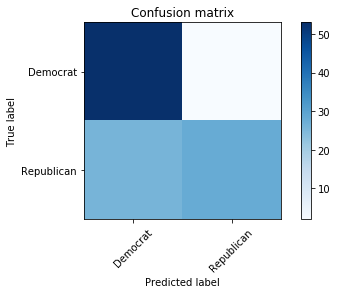

In [52]:
cm = confusion_matrix(ytrue, p)
print(cm)
plt.figure()
plot_confusion_matrix(cm, ['Democrat','Republican'])
plt.show()

# Regression model
The regression model assumes that the all votes go to either democrats or republicans
However, because of third parties dVotePct+rVotePct sometimes don't add up to 100%.
This model will perdict the % of voters who vote Democrat in a district,
and assume that all other vote Republican.
we assume that if there were no 3rd parties half of the 3rd party votes would go republican
and half would go democratic
the vote percentages (with such assumption) are defined to be the adjusted democratic votes
and adjusted republican votes respectively
adjDVote+adjRVote always equals 100, and the code predicts adjDVote

In [212]:
#copy the input dataframe, merge the results df, and drop Id2
rdf = df.copy()
rdf = rdf.merge(hres, on="Id2")
rdf.drop("Id2", axis=1, inplace=True)

#calculate the adjusted democratic vote
advTab = rdf.filter(['dVotePct', 'rVotePct'])
rdf.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)
advTab['adjDVote'] = advTab['dVotePct'] + (1-(advTab['dVotePct']+advTab['rVotePct']))/2
advTab.drop(['dVotePct', 'rVotePct'], axis=1, inplace=True)

advTab

,adjDVote
0,0.318579
1,0.304794
2,0.395046
3,0.297615
4,0.991275
5,0.008376
6,0.995213
7,0.417186
8,0.458472
9,0.401373


In [213]:
cx = rdf.to_numpy('float32')
cy = advTab.to_numpy('float32')
print(cx.shape)
print(cy.shape)

(435, 398)
(435, 1)


In [214]:
cxtrain,cxtest,cytrain,cytest=train_test_split(cx, cy, test_size=0.25, random_state=(int(time.time()) % 1000))

In [ ]:
cmodel = Sequential()
cmodel.add(Dense(264, input_dim=cxtrain.shape[1], activation='relu'))
cmodel.add(Dense(132, activation='relu'))
cmodel.add(Dense(cytrain.shape[1], activation='softmax'))
cmodel.compile(loss='categorical_crossentropy', optimizer='adam')
cmonitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
cmodel.fit(xtrain, ytrain, validation_data=(xtest,ytest), callbacks=[cmonitor], verbose=2, epochs=100)